In [3]:
import sys
sys.path.append('../')

import os
import re
from typing import List, Optional, Tuple, Union

import click
import dnnlib
import numpy as np
import PIL.Image
import torch
from tqdm import tqdm
import mrcfile


import legacy
from camera_utils import LookAtPoseSampler, FOV_to_intrinsics
from torch_utils import misc
from training.triplane_cond import TriPlaneGenerator

from training.utils import color_mask

from matplotlib import pyplot as plt

from pathlib import Path

from rich.progress import track
import json

import imageio
import cv2


In [4]:
def init_conditional_dataset_kwargs(data, mask_data, data_type, resolution=None):
    try:
        if data_type =='seg':
            dataset_kwargs = dnnlib.EasyDict(class_name='training.dataset.ImageSegFolderDataset', path=data, mask_path=mask_data, data_type=data_type, use_labels=True, max_size=None, xflip=False, resolution=resolution)
            dataset_obj = dnnlib.util.construct_class_by_name(**dataset_kwargs) # Subclass of training.dataset.Dataset.
            dataset_kwargs.resolution = dataset_obj.resolution # Be explicit about resolution.
            dataset_kwargs.use_labels = dataset_obj.has_labels # Be explicit about labels.
            dataset_kwargs.max_size = len(dataset_obj) # Be explicit about dataset size.
            return dataset_kwargs, dataset_obj.name
        elif data_type == 'edge':
            dataset_kwargs = dnnlib.EasyDict(class_name='training.dataset.ImageEdgeFolderDataset', path=data, mask_path=mask_data, data_type=data_type, use_labels=True, max_size=None, xflip=False)
            dataset_obj = dnnlib.util.construct_class_by_name(**dataset_kwargs) # Subclass of training.dataset.Dataset.
            dataset_kwargs.resolution = dataset_obj.resolution # Be explicit about resolution.
            dataset_kwargs.use_labels = dataset_obj.has_labels # Be explicit about labels.
            dataset_kwargs.max_size = len(dataset_obj) # Be explicit about dataset size.
            return dataset_kwargs, dataset_obj.name
        else:
            raise click.ClickException(f'Unknown data_type: {data_type}')
    except IOError as err:
        raise click.ClickException(f'--data: {err}')

In [6]:
network_pkl = '/data2/models/eg3d/release/pix2pix3d_edge2cat.pkl'

device = torch.device('cuda')
# Load the network
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].eval().to(device)

In [7]:
data_path = '/data2/datasets/AFHQ_eg3d/afhq_v2_train_cat_512.zip'
mask_data = '/data2/datasets/AFHQ_eg3d/afhqcat_contour_pidinet.zip'
data_type = 'edge'
dataset_kwargs, dataset_name = init_conditional_dataset_kwargs(data_path, mask_data, data_type)
dataset = dnnlib.util.construct_class_by_name(**dataset_kwargs)

In [8]:
focal_length = 4.2647
intrinsics = torch.tensor([[focal_length, 0, 0.5], [0, focal_length, 0.5], [0, 0, 1]], device=device)

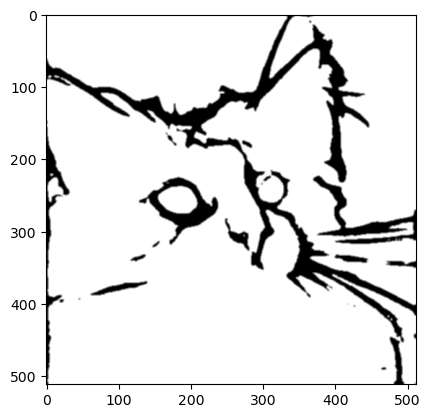

In [10]:
data_id = 3678
batch = dataset[data_id]
batch['mask'] = -(torch.tensor(batch['mask']).to(torch.float32) / 127.5 - 1)
plt.imshow(batch['mask'][0], cmap='gray')

/tmp/ipykernel_3527788/3970038353.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ws = G.mapping(z, torch.tensor(batch['pose']).unsqueeze(0).to(device), {'mask': torch.tensor(batch['mask']).unsqueeze(0).to(device), 'pose': torch.tensor(batch['pose']).unsqueeze(0).to(device)})


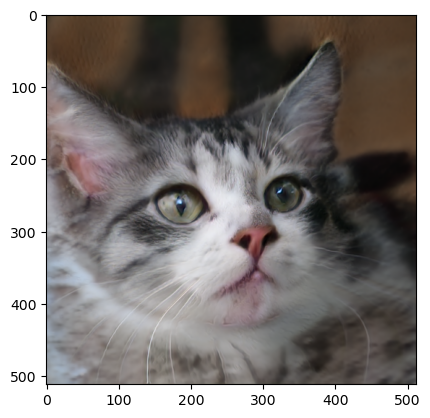

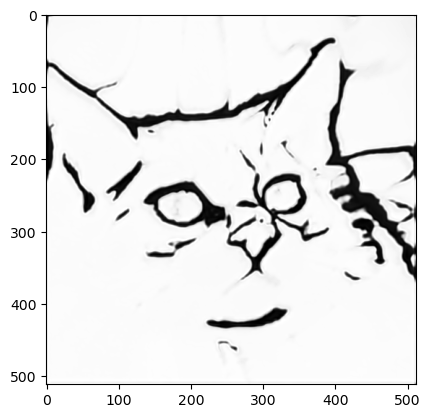

In [13]:
z = torch.from_numpy(np.random.RandomState(int(data_id)).randn(1, G.z_dim).astype('float32')).to(device)
with torch.no_grad():
    ws = G.mapping(z, torch.tensor(batch['pose']).unsqueeze(0).to(device), {'mask': torch.tensor(batch['mask']).unsqueeze(0).to(device), 'pose': torch.tensor(batch['pose']).unsqueeze(0).to(device)})
    out = G.synthesis(ws, torch.tensor(batch['pose']).unsqueeze(0).to(device), noise_mode='const', neural_rendering_resolution=128)
image_color = ((out['image'][0].permute(1, 2, 0).cpu().numpy().clip(-1, 1) + 1) * 127.5).astype(np.uint8)
image_seg = ((out['semantic'][0].permute(1, 2, 0).cpu().numpy().clip(-1, 1) + 1) * 127.5).astype(np.uint8)

plt.imshow(image_color)
plt.show()
plt.imshow(image_seg, cmap='gray')

